# MultiLayer Perceptron

In [2]:
import numpy as np
import pandas as pd
import tensorflow as tf
from tensorflow.keras.models import Model, Sequential
from tensorflow.keras.layers import Embedding, Flatten, Input, Dense, Dropout, ReLU
from tensorflow.keras.layers import Concatenate, Lambda
from tensorflow.keras.regularizers import l2
# Printing
import pprint
import matplotlib.pyplot as plt             
import sys
sys.path.append('../source/')
sys.path.append('../scripts/')
from predictionModel import PredictionModel

In [4]:
#speeds = pd.read_pickle('data/speeds1419.pckl')
#speeds80 = speeds.groupby('data/matching_road').mean().dropna(thresh = int(0.8*len(speeds.columns)))


mergeResults=pd.read_pickle("../data/mergeResults.pckl")
segmentsMeta=pd.read_pickle("../data/segmentsMeta.pckl")

mergedIndex=pd.Series(data=segmentsMeta.loc[mergeResults]['segmentID'].values,index = segmentsMeta['segmentID'].values)
updatedSpeed = pd.read_pickle("../data/updatedSpeedWithHistoricalValues1419.pckl")

counts = pd.read_pickle('../data/counts1419.pckl')
updatedcounts = counts.assign(newIndex = mergedIndex.reindex(counts.index).values)
updatedcounts = updatedcounts[~updatedcounts.newIndex.isna()]
updatedcounts = updatedcounts.groupby('newIndex').sum().loc[updatedSpeed.index]

updatedSpeed = pd.read_pickle("../data/updatedSpeedWithHistoricalValues1419.pckl")

In [5]:
updatedSpeed.head()

time,2018-11-13 14:00:00,2018-11-13 14:15:00,2018-11-13 14:30:00,2018-11-13 14:45:00,2018-11-13 15:00:00,2018-11-13 15:15:00,2018-11-13 15:30:00,2018-11-13 15:45:00,2018-11-13 16:00:00,2018-11-13 16:15:00,...,2018-12-11 16:30:00,2018-12-11 16:45:00,2018-12-11 17:00:00,2018-12-11 17:15:00,2018-12-11 17:30:00,2018-12-11 17:45:00,2018-12-11 18:00:00,2018-12-11 18:15:00,2018-12-11 18:30:00,2018-12-11 18:45:00
newIndex,,,,,,,,,,,,,,,,,,,,,
10275171_0,6.000000,13.500000,6.487879,12.333333,10.000000,2.500000,10.000000,3.8875,3.750000,3.875000,...,0.000000,7.500000,5.750000,2.285714,12.500000,4.000000,3.850000,1.444444,6.000000,3.000000
11027377_0,38.000000,17.000000,11.500000,25.198313,22.916667,7.000000,4.666667,13.5000,46.500000,17.828788,...,12.766667,8.000000,20.000000,35.000000,25.375000,19.500000,38.000000,4.000000,0.000000,12.500000
11027379_0,80.166667,72.750000,72.000000,75.200000,78.000000,69.833333,63.666667,73.6250,82.000000,70.285714,...,71.500000,69.000000,55.250000,72.000000,75.666667,76.777778,50.500000,89.750000,60.000000,71.125000
111437857_0,84.707242,89.400000,94.000000,76.333333,87.500000,74.750000,95.000000,77.5000,44.500000,19.000000,...,6.800000,24.625000,8.333333,15.833333,15.000000,48.500000,86.000000,70.500000,55.000000,62.476190
111848631_0,102.746479,102.333333,101.183099,100.279070,101.642857,98.578313,109.395349,111.0000,109.882353,109.030303,...,108.959184,107.123457,106.111111,109.049180,112.061224,113.850575,113.764706,117.500000,116.323529,109.552632


In [5]:
input_lag, output_lag, sequence_length, valid_split =  1, 1, 20, 0.6

data_model = PredictionModel(updatedSpeed, input_lag, output_lag, sequence_length, valid_split= valid_split)
data_model.preprocessData()
x_train, y_train, x_test, y_test = data_model.trainSplit()

print("x_train shape:", x_train.shape)
print("y_train shape:", y_train.shape)
print("x_test shape:", x_test.shape)
print("y_test shape:", y_test.shape)

x_train shape: (148, 748)
y_train shape: (148, 748)
x_test shape: (99, 748)
y_test shape: (99, 748)


In [4]:
def createMlpModel(loss='MSE',optimizer='Adam',nlayers=1, neuronsPerLayer=64,relu_output=False, nSegments=748):
    
    model = Sequential()
    model.add(Dense(neuronsPerLayer, input_dim = nSegments, name='input_layer'))
    
    for i in range(nlayers-1):    
        model.add(Dense(neuronsPerLayer))
        
    model.add(Dense(nSegments, name='out_layer'))
    if relu_output :
        model.add(ReLU())
    model.compile(loss=loss, optimizer=optimizer)
    return model

In [42]:
model = createMlpModel()
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_layer (Dense)          (None, 64)                47936     
_________________________________________________________________
out_layer (Dense)            (None, 748)               48620     
Total params: 96,556
Trainable params: 96,556
Non-trainable params: 0
_________________________________________________________________


In [6]:
def createMlpModel(loss='MSE',optimizer='Adam', nlayers=1, neuronsPerLayer=64, relu_output=False, nSegments=748):
    
    inputs = Input(shape=(nSegments,), name='input')
    x = Flatten(name='flatten')(inputs)
    
    for i in range(nlayers):    
        x = Dense(neuronsPerLayer/(i+1))(x)
        
    if relu_output :
        predictions = Dense(nSegments, activation='relu', name='out_layer')(x)
    else:
        predictions = Dense(nSegments, name='out_layer')(x)
        
    model = Model(inputs=inputs, outputs=predictions)
    model.compile(loss=loss, optimizer=optimizer)
    return model

In [7]:
data_model.model = createMlpModel(nlayers=1, neuronsPerLayer=64, relu_output=False)
data_model.model.summary()
data_model.model.fit(x_train, y_train, validation_data = (x_test, y_test), epochs=40)

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input (InputLayer)           (None, 748)               0         
_________________________________________________________________
flatten (Flatten)            (None, 748)               0         
_________________________________________________________________
dense (Dense)                (None, 64)                47936     
_________________________________________________________________
out_layer (Dense)            (None, 748)               48620     
Total params: 96,556
Trainable params: 96,556
Non-trainable params: 0
_________________________________________________________________
Train on 148 samples, validate on 99 samples
Epoch 1/40
148/148 [==============================] - 1s 4ms/step - loss: 4306.2040 - val_loss: 3317.8025
Epoch 2/40
148/148 [==============================] - 0s 210us/step - loss: 2709.7042 - val_loss: 1740.7898
Epoch 3/40


In [18]:
def plotPredHeatMap(data_model,cost=None, save=False):
    yDF=data_model.restorePredictionsAsDF(data_model.y)
    predDF = data_model.restorePredictionsAsDF(data_model.predict('full'))
    
    if cost :
        colors= cost(yDF,predDF)
    else :
        colors = ((np.abs(yDF - predDF)+1)/(yDF+1)).clip(upper=1)
    
    plt.figure(figsize=(18,12))
    plt.imshow(colors,aspect='auto')
    plt.colorbar()
    if save:
        plt.savefig("Heatmap.png", bbox_inches='tight')
    plt.show()

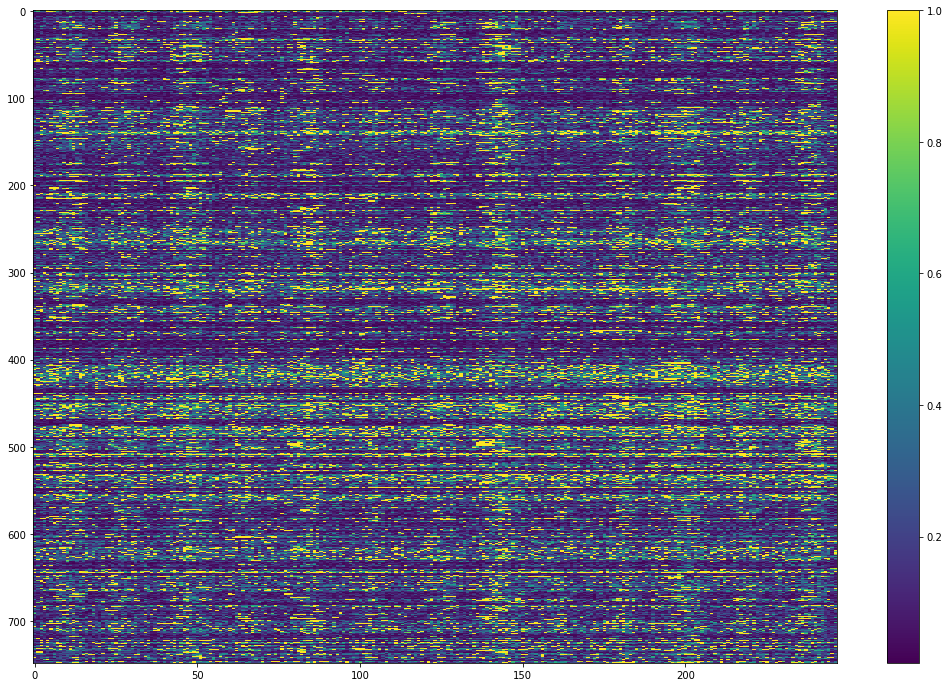

In [19]:
plotPredHeatMap(data_model, save=True)

In [8]:
import Plotting
import folium
import matplotlib

In [36]:
def plotPredictions(segments,data_model, yDF,predDF, timesteps, mergedIndex, updatedcounts, folium_map=None):
    if folium_map == None :
        folium_map = Plotting.getFoliumMap()
    layers=[]
    colors = ((np.abs(yDF.clip(lower=15) - predDF.clip(lower=15))+1)/(yDF.clip(lower=15)+1)).clip(upper=1)
    laggedX = data_model.restorePredictionsAsDF(data_model.x)
    predSegs = segments[segments.segmentID.isin(mergedIndex[mergedIndex.isin(yDF.index)].index)]
    segment_overall_mean = [data_model.data.mean(axis=1).loc[mergedIndex.loc[idx]] for idx in predSegs.segmentID]
    segment_timestamp_mean = data_model.data.groupby(pd.DatetimeIndex(data_model.data.columns).time,axis=1).mean()
    for t in timesteps :  
        colorList=[colors[t].loc[mergedIndex.loc[idx]] for idx in predSegs.segmentID]
        y= [yDF[t].loc[mergedIndex.loc[idx]] for idx in predSegs.segmentID]
        preds = [predDF[t].loc[mergedIndex.loc[idx]] for idx in predSegs.segmentID]
        segCounts=[updatedcounts[t].loc[mergedIndex.loc[idx]] for idx in predSegs.segmentID]
        timestampLaggedX= [laggedX[t].loc[mergedIndex.loc[idx]] for idx in predSegs.segmentID]
        
        current_segment_timestamp_mean = [segment_timestamp_mean[t.time()].loc[mergedIndex.loc[idx]] for idx in predSegs.segmentID]
        
        popups = ["segment : {:},<br> y : {:.2f},<br> pred : {:.2f},<br> %error : {:.0f}%,<br> count : {:}<br>mean: {:}<br>timestamp_mean: {:}<br>x: {:} "\
                  .format(seg,yi,predi,props*100,count,mean,timestamp_mean,np.array(x).astype(int)) 
                  for seg,yi,predi,props,count,mean,timestamp_mean,x 
                  in zip(predSegs.segmentID,y,preds,colorList,segCounts,segment_overall_mean,current_segment_timestamp_mean,timestampLaggedX)]
        pos = yDF.columns.get_loc(t)
        layer = getPredictionLayer(predSegs,colorList,folium_map,str(t),popups)
        layers.append(layer)
        
    return Plotting.stackHistotyLayers([*layers,folium.TileLayer()],folium_map)

def getPredictionLayer(segments,colors,folium_map,name='layer',popups=[]):
    print(colors)
    exit()
    layer = folium.plugins.FeatureGroupSubGroup(folium_map,name=name,show=False, overlay=False)
    [folium.PolyLine(locations=[lo[::-1] for lo in x['coordinates']], color=matplotlib.colors.rgb2hex(plt.cm.brg_r(color/2)),popup=pop).add_to(layer) for x,color,pop in zip(segments['loc'],colors,popups)]
    return layer

In [37]:
yDF=data_model.restorePredictionsAsDF(data_model.y)
predDF = data_model.restorePredictionsAsDF(data_model.predict('full'))

folium_map = plotPredictions(segmentsMeta, data_model, yDF, predDF, yDF.columns[np.r_[:len(yDF.columns)-1:10j].astype(int)], mergedIndex, updatedcounts)


[0.5436959204735694, 0.5436959204735694, 0.02086838153230042, 0.08349725542735657, 0.06034854510882957, 0.025373113362428344, 0.04405756219580012, 0.05686121401579484, 0.09124532702505855, 0.013209491694739128, 0.030013190375434026, 0.08630293637967956, 0.027615608365439845, 0.09992392331559141, 0.09992392331559141, 0.1260258265904018, 0.13903625618977508, 0.13903625618977508, 0.13903625618977508, 0.1260258265904018, 0.03010069141486031, 0.1514294381869042, 0.13903625618977508, 0.1514294381869042, 0.1514294381869042, 0.09179875174945688, 0.01896384910300926, 0.025797815198177296, 0.033760935989851804, 0.01896384910300926, 0.12435903359219377, 0.18522690049367935, 0.18522690049367935, 0.12435903359219377, 0.12435903359219377, 0.1700694871985394, 0.025797815198177296, 0.025797815198177296, 0.10160123384915866, 0.10160123384915866, 0.10160123384915866, 0.025797815198177296, 0.1514294381869042, 0.09179875174945688, 0.09179875174945688, 0.1514294381869042, 0.09179875174945688, 0.10160123384

KeyboardInterrupt: 

ERROR:root:Invalid alias: The name clear can't be aliased because it is another magic command.
ERROR:root:Invalid alias: The name more can't be aliased because it is another magic command.
ERROR:root:Invalid alias: The name less can't be aliased because it is another magic command.
ERROR:root:Invalid alias: The name man can't be aliased because it is another magic command.


In [9]:
color = 0.5436959204735694
plt.cm.brg_r(color/2)

(0.5411764705882353, 0.45882352941176474, 0.0, 1.0)

In [33]:
folium_map.save('test.html')

In [34]:
tf.keras.backend.clear_session()